In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=42

### 1) 이미지 스케일링

In [ ]:
# 이미지 전처리로 스케일링을 합니다
img_datagen = ImageDataGenerator( rescale = 1.0/255. )

### 2) x_train, y_train, x_validation, y_validation 생성

#### 가. x_train 생성

In [ ]:
# 이미지 전처리로 이미지 크기를 (256, 256)으로 줄입니다
x_train_dir = 'C:/Users/visbic/Desktop/minji/projects/water_segment/data/Training/[원천]train_water_data'
x_train_generator = img_datagen.flow_from_directory(x_train_dir,
                                                  batch_size=2401,
                                                    shuffle=False,
                                                    seed=seed,
#                                                   class_mode='binary',
                                                  color_mode="rgb")#"grayscale"

Found 2401 images belonging to 1 classes.


In [ ]:
x_train_generator

In [ ]:
x_train, _ = x_train_generator.next()
x_train.shape

(2401, 256, 256, 3)

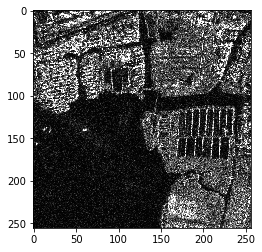

In [ ]:
# x_train 예시 보기
plt.imshow(x_train[0]) 
plt.show()

#### 나. y_train 생성

In [ ]:
# 이미지 전처리로 이미지 크기를 (256, 256)으로 줄입니다
y_train_dir = 'C:/Users/visbic/Desktop/minji/projects/water_segment/data/Training/[라벨]train_water_labeling'
y_train_generator = img_datagen.flow_from_directory(y_train_dir,
                                                  batch_size=2401,
                                                    shuffle=False,
                                                    seed=seed,
#                                                   class_mode='binary',
                                                  color_mode="grayscale")

Found 2401 images belonging to 1 classes.


In [ ]:
y_train, _ = y_train_generator.next()
y_train.shape

(2401, 256, 256, 1)

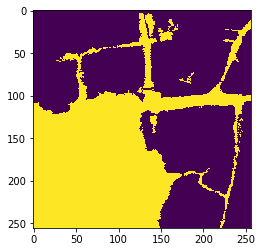

In [ ]:
# x_train 예시 보기
plt.imshow(y_train.reshape(2401, 256, 256)[0]) 
plt.show()

#### 다. x_validation 생성

In [ ]:
# 이미지 전처리로 이미지 크기를 (256, 256)으로 줄이고 grayscale이미지로 변환합니다.
x_validation_dir = 'C:/Users/visbic/Desktop/minji/projects/water_segment/data/Validation/[원천]validate_water_data'
x_validation_generator = img_datagen.flow_from_directory(x_validation_dir,
                                                  batch_size=300,
                                                         shuffle=False,
                                                         seed=seed,
#                                                   class_mode='binary',
                                                  color_mode="rgb")#"grayscale"

Found 300 images belonging to 1 classes.


In [ ]:
x_validation, _ = x_validation_generator.next()
x_validation.shape

(300, 256, 256, 3)

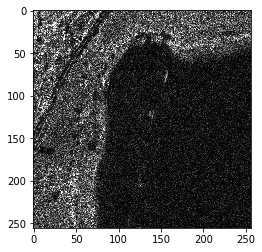

In [ ]:
plt.imshow(x_validation[0]) # 첫 번째 이미지
plt.show()

#### 라. y_validation 생성

In [ ]:
# 이미지 전처리로 이미지 크기를 (256, 256)으로 줄입니다
y_validation_dir = 'C:/Users/visbic/Desktop/minji/projects/water_segment/data/Validation/[라벨]validate_water_labeling'
y_validation_generator = img_datagen.flow_from_directory(y_validation_dir,
                                                  batch_size=300,
                                                         shuffle=False,
                                                         seed=seed,
#                                                   class_mode='binary',
                                                  color_mode="grayscale")

Found 300 images belonging to 1 classes.


In [ ]:
y_validation, _ = y_validation_generator.next()
y_validation.shape

(300, 256, 256, 1)

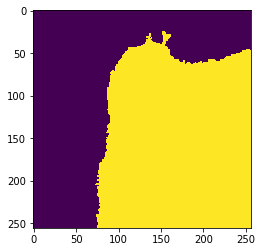

In [ ]:
# x_train 예시 보기
plt.imshow(y_validation.reshape(300, 256, 256)[0]) 
plt.show()

In [ ]:
# shape 확인
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(2401, 256, 256, 3)
(2401, 256, 256, 1)
(300, 256, 256, 3)
(300, 256, 256, 1)


### 3) train

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy


from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from glob import glob
from sklearn.model_selection import train_test_split
# from model import build_model
# from utils import *
# from metrics import *

In [ ]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []

#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)

#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output

#     return output, skip_connections

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model

if __name__ == "__main__":
    model = build_model((256, 256, 3))
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

In [ ]:
def read_image(x):
    x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset

if __name__ == "__main__":
    np.random.seed(seed) # 42
    tf.random.set_seed(seed) # 42
#     create_dir("files")

#     train_path = "../1/new_data/train/"
#     valid_path = "../1/new_data/valid/"

#     ## Training
#     x_train = sorted(glob(os.path.join(train_path, "image", "*.jpg")))
#     y_train = sorted(glob(os.path.join(train_path, "mask", "*.jpg")))

#     ## Shuffling
#     x_train, y_train = shuffling(x_train, y_train)

#     ## Validation
#     x_validation = sorted(glob(os.path.join(valid_path, "image", "*.jpg")))
#     y_validation = sorted(glob(os.path.join(valid_path, "mask", "*.jpg")))

#     model_path = "files/model.h5"
    batch_size = 16
    epochs = 300
    lr = 1e-4
    shape = (256, 256, 3)

    model = build_model(shape)
    metrics = [
        dice_coef,
        iou,
        Recall(),
        Precision()
    ]
    
    train_dataset = tf_dataset(x_train, y_train, batch=batch_size)
    valid_dataset = tf_dataset(x_validation, y_validation, batch=batch_size)
    
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

    callbacks = [
#         ModelCheckpoint(model_path),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
#         CSVLogger("files/data.csv"),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
    ]

    train_steps = (len(x_train)//batch_size)
    valid_steps = (len(x_validation)//batch_size)

    if len(x_train) % batch_size != 0:
        train_steps += 1

    if len(x_validation) % batch_size != 0:
        valid_steps += 1

    model.fit(train_dataset,
            epochs=epochs,
            validation_data=valid_dataset,
            steps_per_epoch=train_steps,
            validation_steps=valid_steps,
            callbacks=callbacks,
            shuffle=False)

Train for 151 steps, validate for 19 steps
Epoch 1/300
  1/151 [..............................] - ETA: 5:17WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: lr


ValueError: Dimensions must be equal, but are 65536 and 131072 for 'loss/concatenate_21_loss/mul' (op: 'Mul') with input shapes: [?,65536], [?,131072].